In [248]:
library(quantmod)
library(ggplot2)
library(tseries)
library(gridExtra)
library(forecast)
library(lmtest)

In [249]:
# Load the US National Home Price data from CSV
HomePrice = read.csv("./US_National_Home_price.csv")

# Format the data to xts
HomePrice = xts(HomePrice, order.by=as.Date(HomePrice$DATE, format="%Y-%m-%d")) 
storage.mode(HomePrice) = "numeric"
HomePrice$DATE = NULL

Warning message in storage.mode(HomePrice) = "numeric":
“NAs introduced by coercion”

In [250]:
# Observe the first few rows of data
head(HomePrice)

           CSUSHPINSA
1987-01-01     63.753
1987-02-01     64.153
1987-03-01     64.490
1987-04-01     64.995
1987-05-01     65.570
1987-06-01     66.238

Don't know how to automatically pick scale for object of type xts/zoo. Defaulting to continuous.


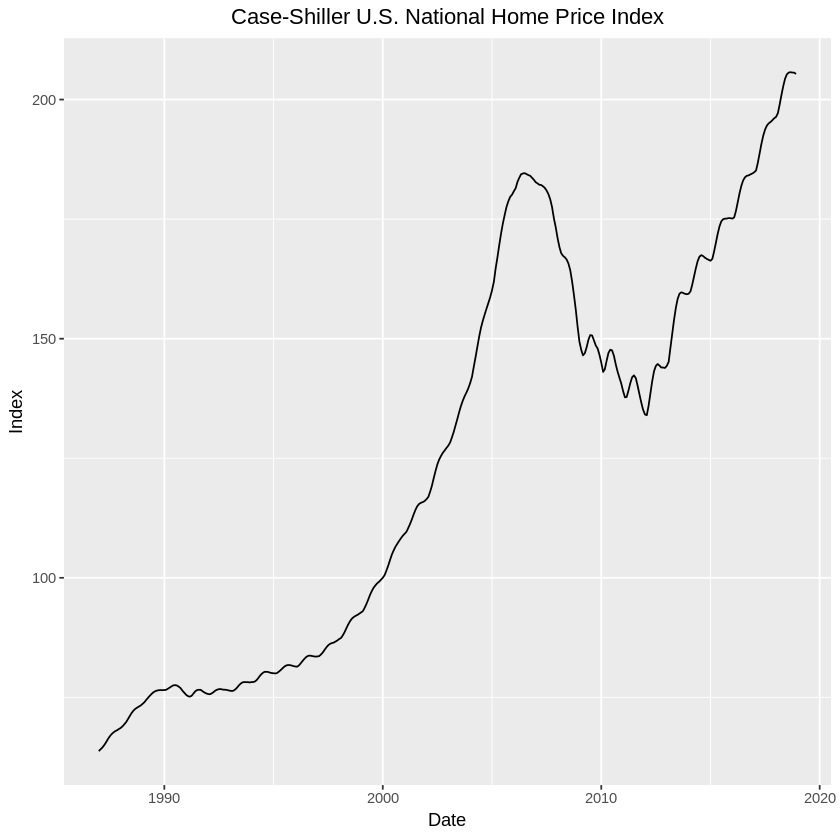

In [251]:
# Plot the price index
ggplot(HomePrice, aes(Index)) + 
    geom_line(aes(y = HomePrice$CSUSHPINSA))+
    ggtitle("Case-Shiller U.S. National Home Price Index") +
    labs(x = "Date", y = "Index") + 
    theme(plot.title = element_text(hjust = 0.5))

## ADF Test

The adf test suggest that the model is non-statitionary. With the p-value at 0.4123, we cannot reject the null hypothesis that an unit root is present.

This suggest for the need to perform differencing

In [252]:
# Perform adf test with time series of HomePrice
# See https://stackoverflow.com/questions/16447461/adf-test-returning-p-0-99-with-xts-but-returning-p-0-01-with-coredataxts

adf.test(as.ts(HomePrice))


	Augmented Dickey-Fuller Test

data:  as.ts(HomePrice)
Dickey-Fuller = -2.3903, Lag order = 7, p-value = 0.4123
alternative hypothesis: stationary


## ACF & PACF Chart

The ACF decays very slowly as the lag increases. This further confirms the need to difference the time series data.

The PACF displays a sharp cut-off at lag 1. This could be identified as an AR signature. 

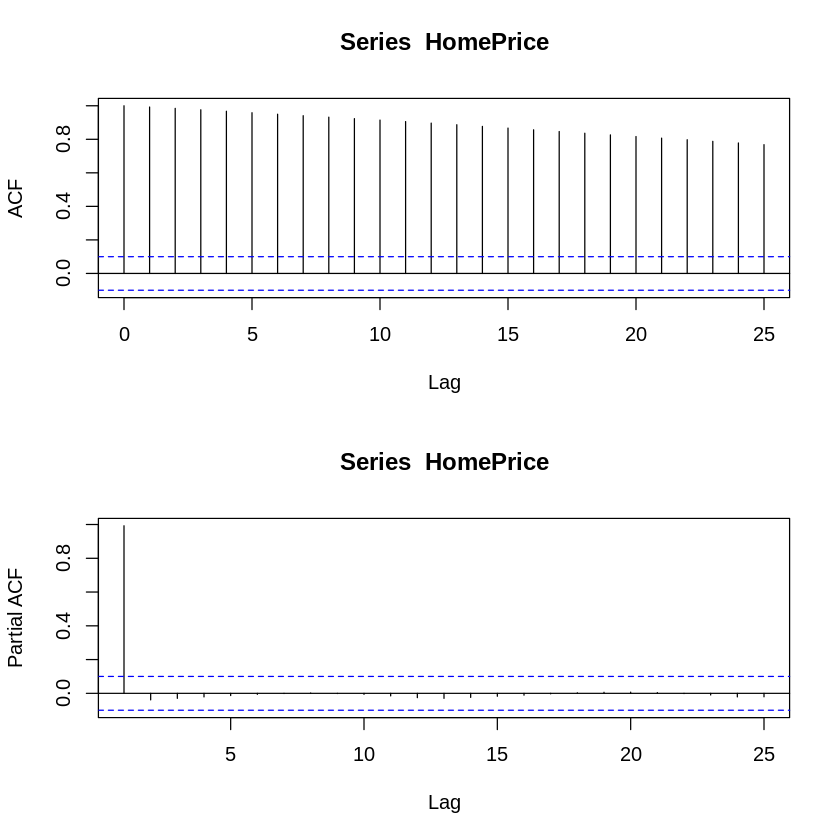

In [253]:
# Plot ACF & PACF for HomePrice

par(mfrow=c(2,1))
acf(HomePrice)
pacf(HomePrice)

## Differencing

### Diff 1

Applying diff 1 to the data, we obtained a p-value of 0.2558 on the ADF test. This suggest that the data is still not stationary at the 1% significance level.

In [255]:
# Applying diff1
diff1 = diff(HomePrice, differences = 1)
diff1 = diff1[2:nrow(diff1)]
adf.test(as.ts(diff1))


	Augmented Dickey-Fuller Test

data:  as.ts(diff1)
Dickey-Fuller = -2.7611, Lag order = 7, p-value = 0.2558
alternative hypothesis: stationary


### Diff 2

Applying diff 2 to the data, we obtained a p-value of 0.01 on the ADF test, suggesting that we can reject the null hypothesis where a unit root is present. 

In [261]:
# Applying diff2
diff2 = diff(HomePrice, differences = 2)
diff2 = diff2[3:nrow(diff2)]
adf.test(as.ts(diff2))

Warning message in adf.test(as.ts(diff2)):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  as.ts(diff2)
Dickey-Fuller = -15.602, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


## ACF & PACF of diff(2)

### ACF

The ACF chart for diff(2) shows that there are still significant correlation between the time series that are significantly different from 0 (as observed from the blue dotted lines). 

The sinusiodal graph may suggest the need for AR(2) graph.

However, we can also observe a negative correlation at lag 6 and a strong positive correlation at lag 12. This may suggest a seasonal AR with a period of 12.

### PACF

The PACF chart shows an AR(1) signature where PACF shows a sharp cut-off at the first lag.

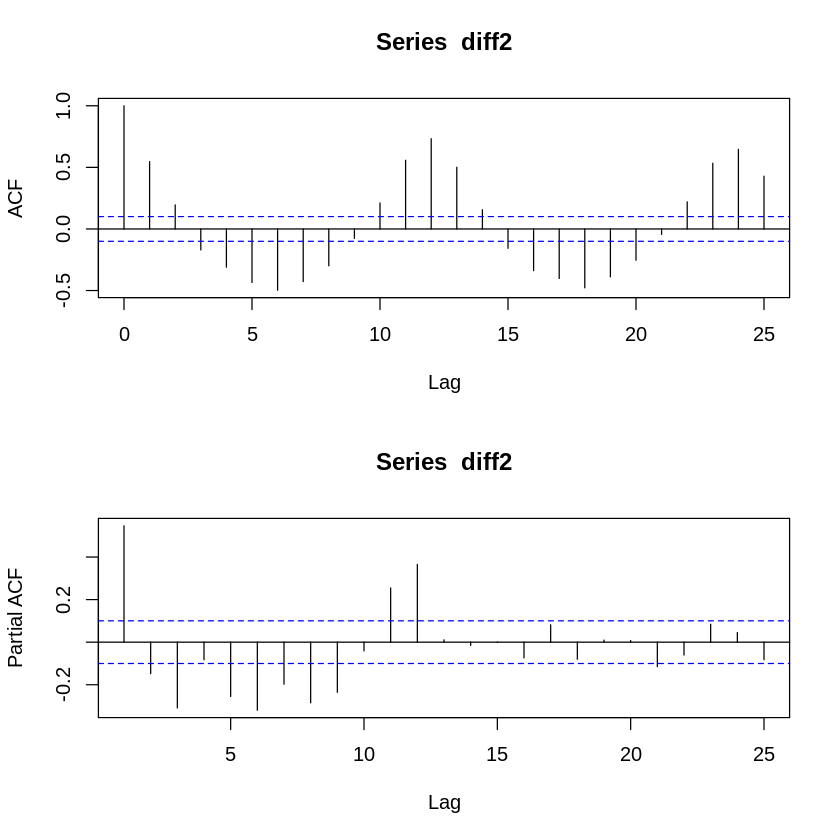

In [264]:
# Plot ACF & PACF for differenced model
# https://stats.stackexchange.com/questions/49571/understanding-the-blue-dotted-lines-in-an-acf-from-r

par(mfrow=c(2,1))
acf(diff2)
pacf(diff2)

## Model 1 - ARIMA(0, 2, 0)


Name | Value
--- | ---
Variance | 0.1703
Log likelihood | -203.9
AIC | 409.79
RMSE | 0.4115899

ACF chart still continues to diplay the sinusoidal wave, peaking at lag 6, 12, 18, 24. This suggest the need for AR(2). 

Ljung-Box-Pierce statistics shows that the model's accumulated residual autocorrelation is not significant up to lag 20. 


Call:
arima(x = window(HomePrice), order = c(0, 2, 0), method = "ML")


sigma^2 estimated as 0.1703:  log likelihood = -203.9,  aic = 409.79

Training set error measures:
                       ME      RMSE       MAE         MPE      MAPE      MASE
Training set -0.001927416 0.4115899 0.2602374 0.002485472 0.1939264 0.3497458
                  ACF1
Training set 0.5469119


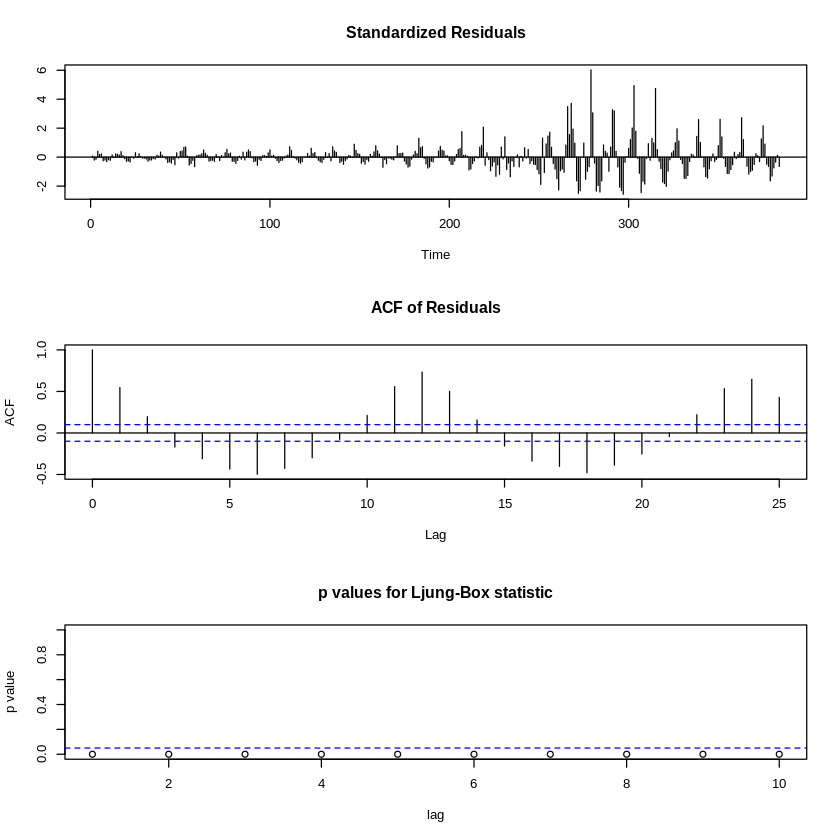

In [287]:
model1 <- arima(window(HomePrice), order=c(0,2,0), method = "ML")

# Print summary of model1
summary(model1)

# Print diagnostics of model1
tsdiag(model1)

## Model 3 - ARIMA(2, 2, 0)


Name | Value
--- | ---
Variance | 0.1166
Log likelihood | -131.82
AIC | 269.64
RMSE | 0.3406494

ACF chart shows smaller spikes compared to model1's. However, it can still be observed that the spiked at 6, 12, 18, 24 is still significant. This suggest that there are correlation that has yet to be accounted for.

Ljung-Box-Pierce statistics shows that the model's accumulated residual autocorrelation is not significant up to lag 20, except for lag 1.

Both coefficient, ar1 & ar2, are tested to be significantly different from zero.

Overall, model3 outperforms model1 and model2 and should be chosen for non-seasonal arima model. 


Call:
arima(x = window(HomePrice), order = c(2, 2, 0), method = "ML")

Coefficients:
         ar1      ar2
      0.6277  -0.1485
s.e.  0.0506   0.0505

sigma^2 estimated as 0.1166:  log likelihood = -131.82,  aic = 269.64

Training set error measures:
                      ME      RMSE       MAE         MPE      MAPE      MASE
Training set -0.00141818 0.3406494 0.2080001 0.001291073 0.1556069 0.2795416
                    ACF1
Training set -0.04423696



z test of coefficients:

     Estimate Std. Error z value  Pr(>|z|)    
ar1  0.627713   0.050562 12.4146 < 2.2e-16 ***
ar2 -0.148481   0.050537 -2.9381  0.003302 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


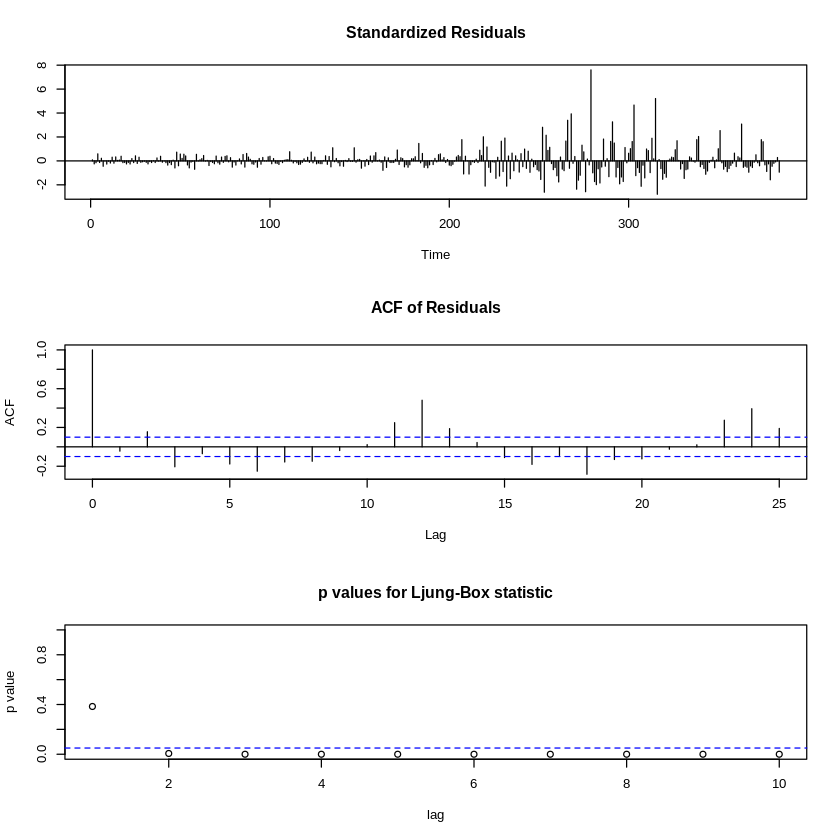

In [291]:
model3 <- arima(window(HomePrice), order=c(2,2,0), method = "ML")

# Print summary of model3
summary(model3)

# Coefficient test of ma1 and ma2
coeftest(model3)

# Print diagnostics of model2
tsdiag(model3)

## Model 3 - ARIMA(0, 2, 2)


Name | Value
--- | ---
Variance | 0.1101
Log likelihood | -120.87
AIC | 247.73
RMSE | 0.3309

ACF chart shows smaller spikes compared to model1's. However, it can still be observed that the spiked at 6, 12, 18, 24 is still significant. This suggest that there are correlation that has yet to be accounted for.

Ljung-Box-Pierce statistics shows that the model's accumulated residual autocorrelation is significant on lag 1, 2, 3 and 4.

Both coefficient, ma1 & ma2, are tested to be significantly different from zero.


Call:
arima(x = window(HomePrice), order = c(0, 2, 2), method = "ML")

Coefficients:
         ma1     ma2
      0.6201  0.4156
s.e.  0.0458  0.0466

sigma^2 estimated as 0.1101:  log likelihood = -120.87,  aic = 247.73

Training set error measures:
                       ME      RMSE       MAE         MPE      MAPE      MASE
Training set -0.001339956 0.3309369 0.2003839 0.001235961 0.1496965 0.2693058
                    ACF1
Training set 0.001531978



z test of coefficients:

    Estimate Std. Error z value  Pr(>|z|)    
ma1 0.620150   0.045808 13.5379 < 2.2e-16 ***
ma2 0.415642   0.046551  8.9288 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


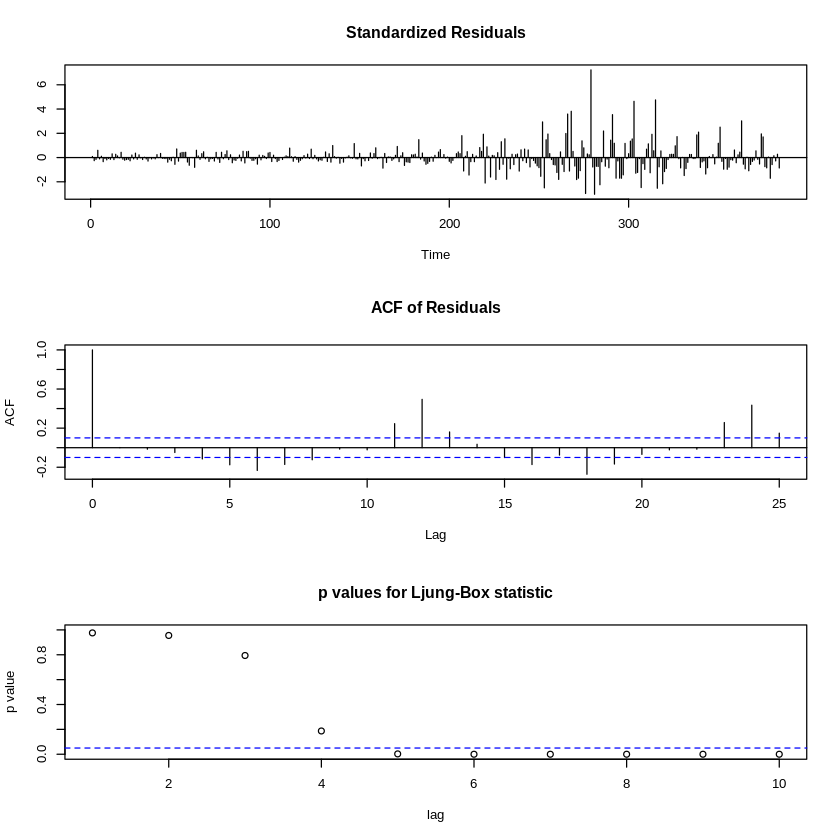

In [290]:
model3 <- arima(window(HomePrice), order=c(0,2,2), method = "ML")

# Print summary of model3
summary(model3)

# Coefficient test of ma1 and ma2
coeftest(model3)

# Print diagnostics of model3
tsdiag(model3)

## Seasonal ARIMA

As suggested by the high positive correlation at lag 12, it is highly possible that the model would be seasonal with period 12.


Call:
arima(x = window(diff2), order = c(0, 2, 0), seasonal = list(order = c(2, 0, 
    0), period = 12), method = "ML")

Coefficients:
        sar1    sar2
      0.2328  0.1118
s.e.  0.0504  0.0506

sigma^2 estimated as 0.3146:  log likelihood = -320.08,  aic = 646.15

Training set error measures:
                       ME      RMSE       MAE MPE MAPE     MASE       ACF1
Training set -0.001098302 0.5594636 0.3319833 Inf  Inf 1.362581 -0.6361369



z test of coefficients:

     Estimate Std. Error z value  Pr(>|z|)    
sar1 0.232763   0.050421  4.6164 3.905e-06 ***
sar2 0.111836   0.050641  2.2084   0.02722 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


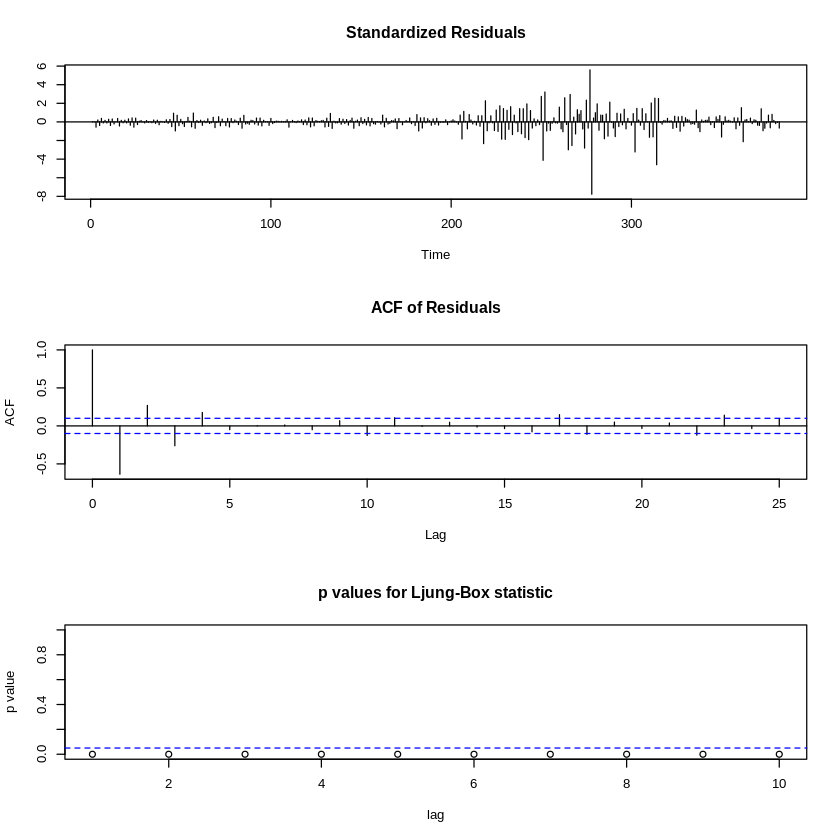

In [284]:
model4 <- arima(window(diff2), order=c(0,2,0), seasonal=list(order=c(2,0,0),period=12),  method = "ML")
# Print summary of model4
summary(model4)

# Coefficient test of ma1 and ma2
coeftest(model4)

# Print diagnostics of model4
tsdiag(model4)

Don't know how to automatically pick scale for object of type xts/zoo. Defaulting to continuous.


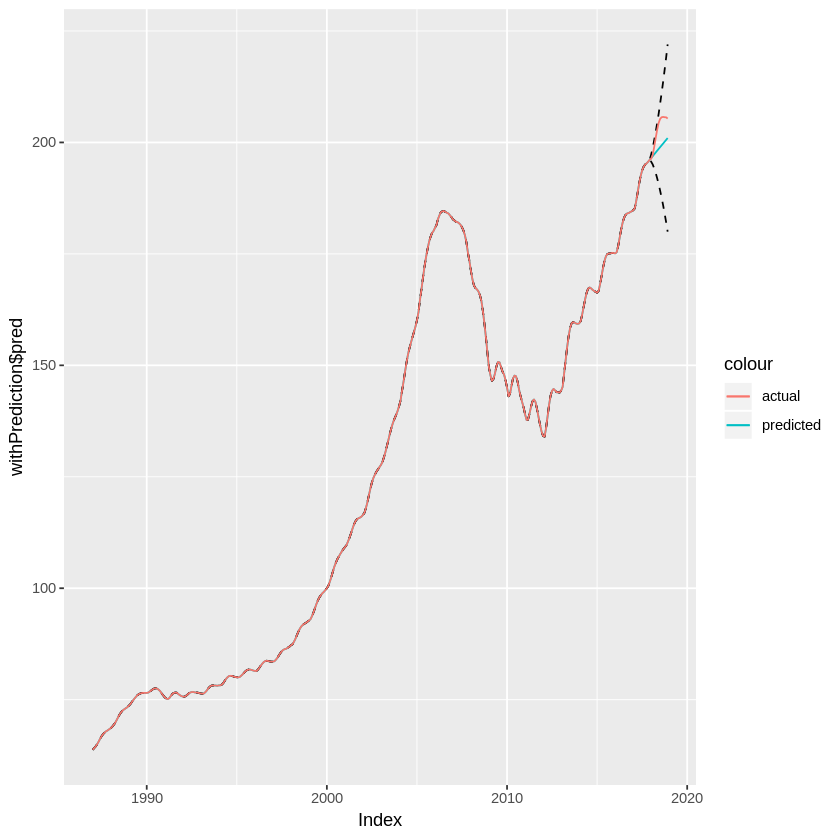

In [116]:
periodToForecast = 12
trainPeriod = nrow(HomePrice)-periodToForecast
train = HomePrice[1:trainPeriod]

fit = arima(train, order=c(0,2,0),  method = "ML")
predictions = predict(fit,n.ahead=periodToForecast,se.fit=TRUE)

# Create vectors with prediction, 2 * SE bounds
pred = c()
upper = c()
lower = c()
for(i in 1:nrow(HomePrice)){
    if(i <= nrow(HomePrice) - periodToForecast){
        pred[i] = HomePrice$CSUSHPINSA[i]
        upper[i] = HomePrice$CSUSHPINSA[i]
        lower[i] = HomePrice$CSUSHPINSA[i]
    }else{
        p = i - trainPeriod
        pred[i] = predictions$pred[p]
        upper[i] = predictions$pred[p] + 2*predictions$se[p]
        lower[i] = predictions$pred[p] - 2*predictions$se[p]
    }
}

withPrediction = merge(HomePrice, pred, upper, lower)

ggplot(withPrediction, aes(Index)) + 
    geom_line(aes(y = withPrediction$pred, color="predicted")) +
    geom_line(aes(y = withPrediction$upper), linetype="dashed") +
    geom_line(aes(y = withPrediction$lower), , linetype="dashed") +
    geom_line(aes(y = withPrediction$CSUSHPINSA, color="actual"))

# acf(fit$residuals)
# pacf(fit$residuals)


Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


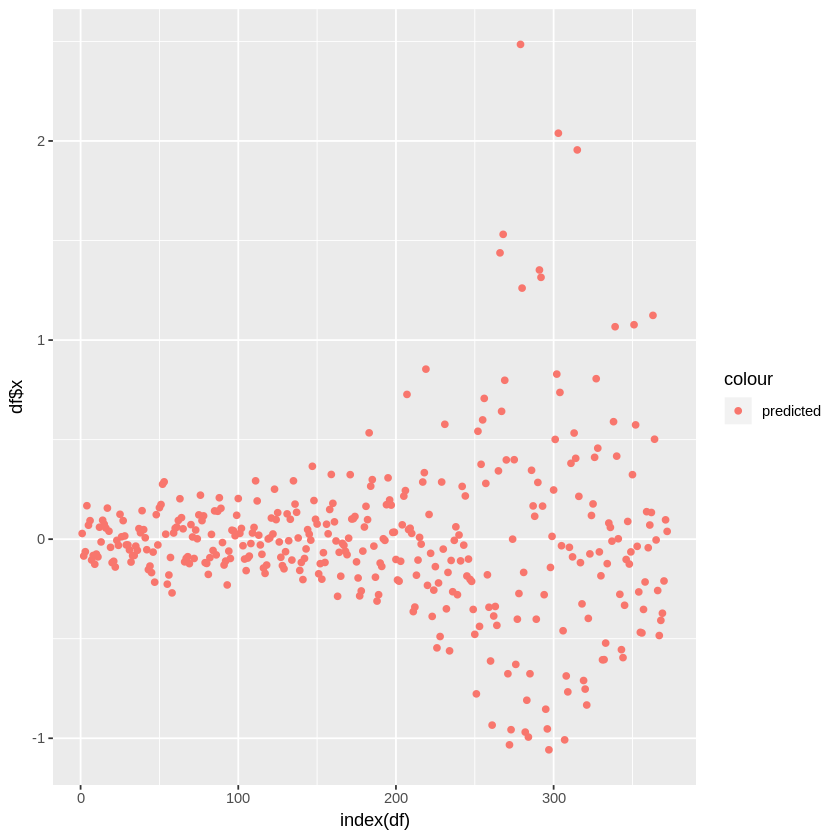

In [117]:
df = as.data.frame(fit$residuals)
ggplot(df, aes(index(df))) + 
    geom_point(aes(y = df$x, color="predicted"))

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


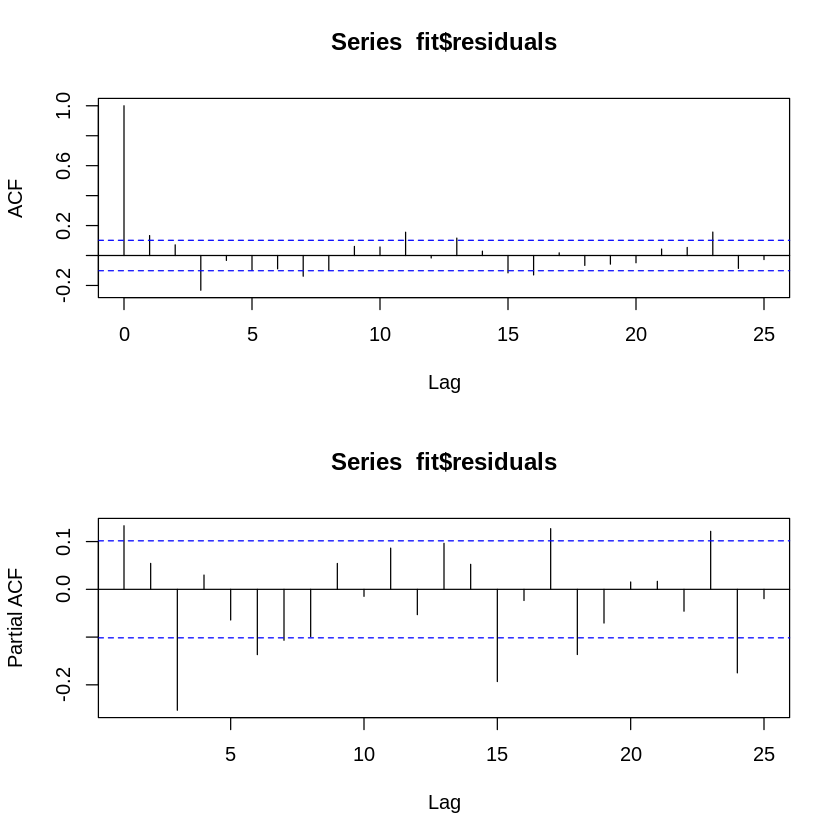

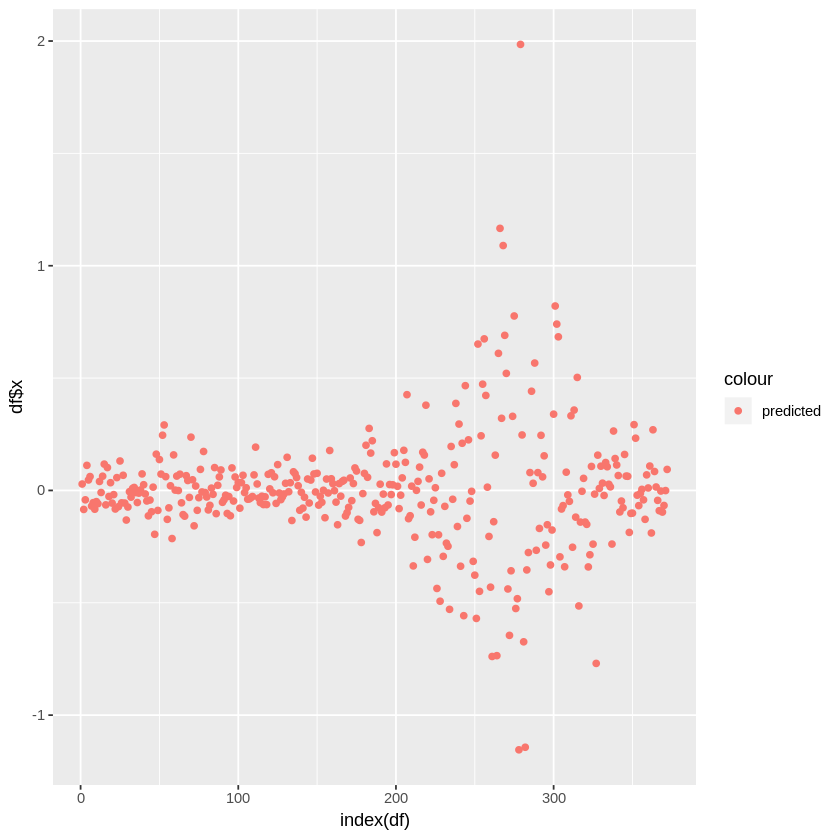

In [235]:
fit = arima(train, order=c(0,2,0), seasonal=list(order=c(2,0,0),period=12),  method = "ML")

# accuracy(fit)
# coeftest(fit)

par(mfrow=c(2,1))
acf(fit$residuals)
pacf(fit$residuals)

df = as.data.frame(fit$residuals)
ggplot(df, aes(index(df))) + 
    geom_point(aes(y = df$x, color="predicted"))

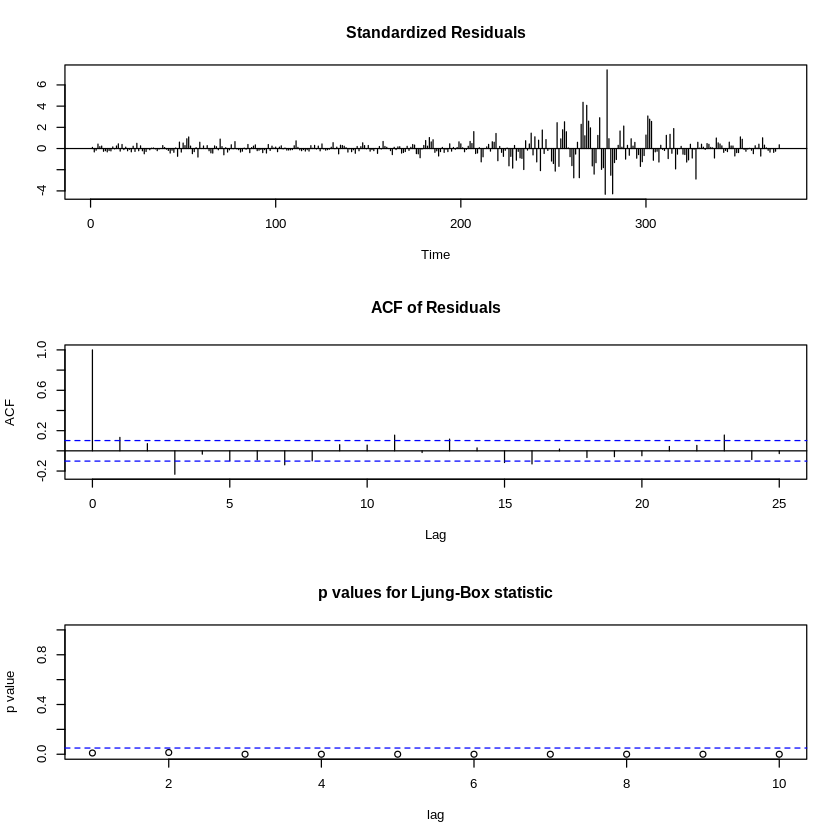

In [236]:
tsdiag(fit)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-8.923999e-05,0.3307095,0.1982458,0.001868618,0.1502042,0.267474,3.615309e-05


Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


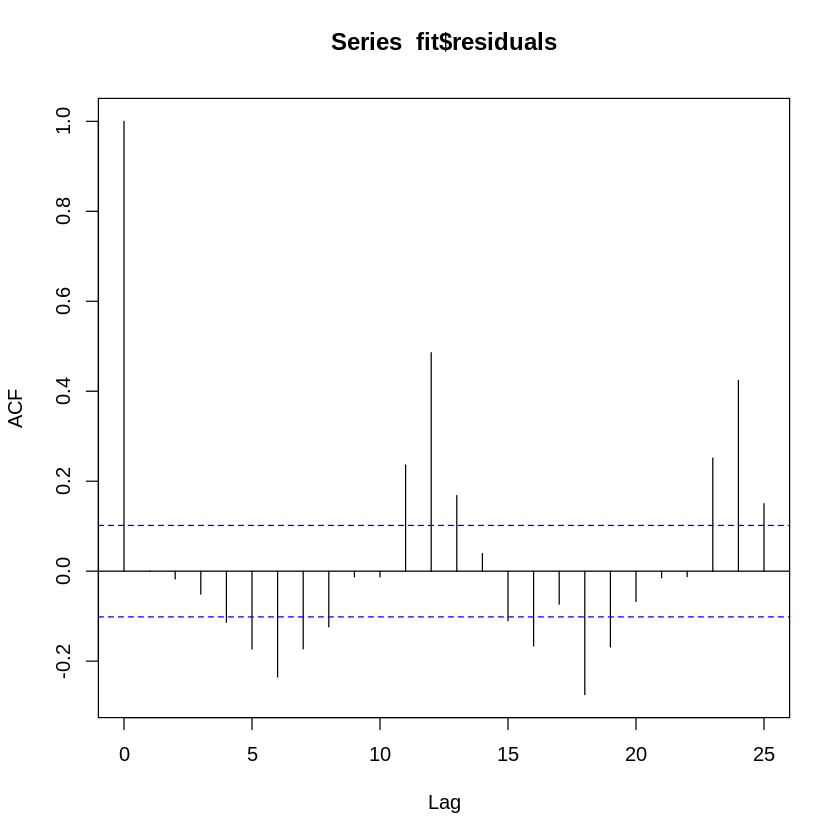


	Box-Pierce test

data:  fit$residuals
X-squared = 4.8622e-07, df = 1, p-value = 0.9994


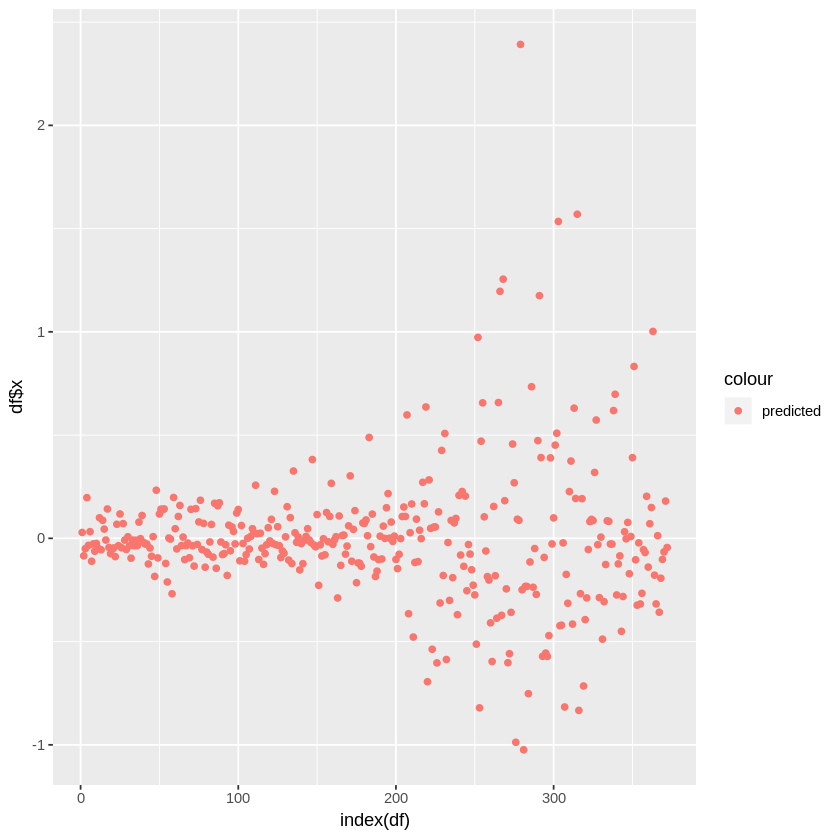

In [226]:
fit = arima(train, order=c(0,2,2), method = "ML")
accuracy(fit)
#coeftest(fit)
acf(fit$residuals)
df = as.data.frame(fit$residuals)
ggplot(df, aes(index(df))) + 
    geom_point(aes(y = df$x, color="predicted"))
Box.test(fit$residuals, lag = 1)

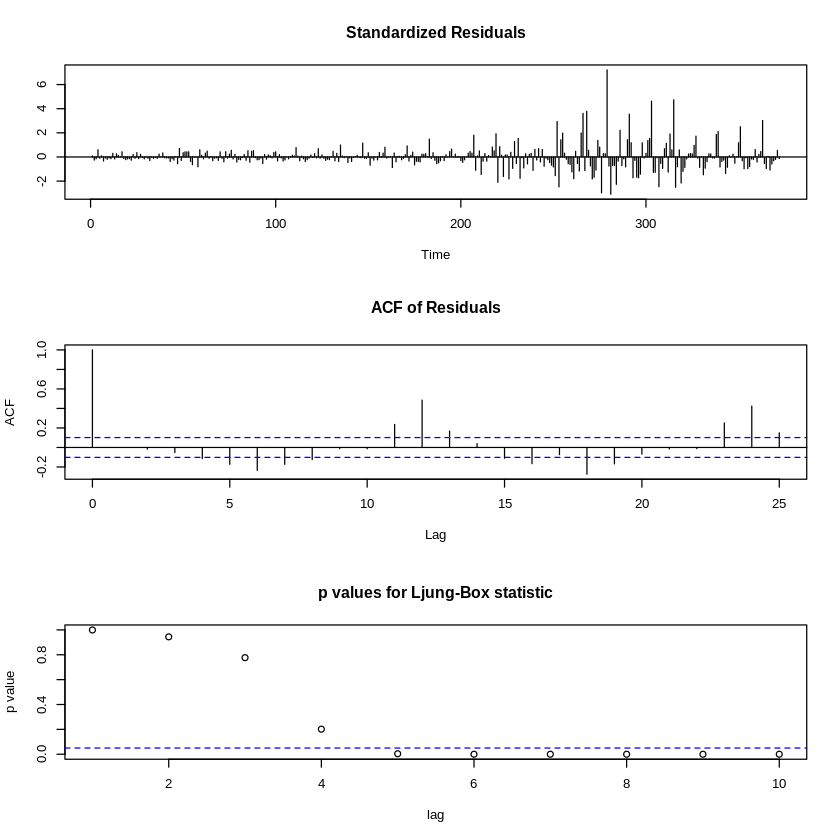

In [227]:
tsdiag(fit)

Don't know how to automatically pick scale for object of type xts/zoo. Defaulting to continuous.


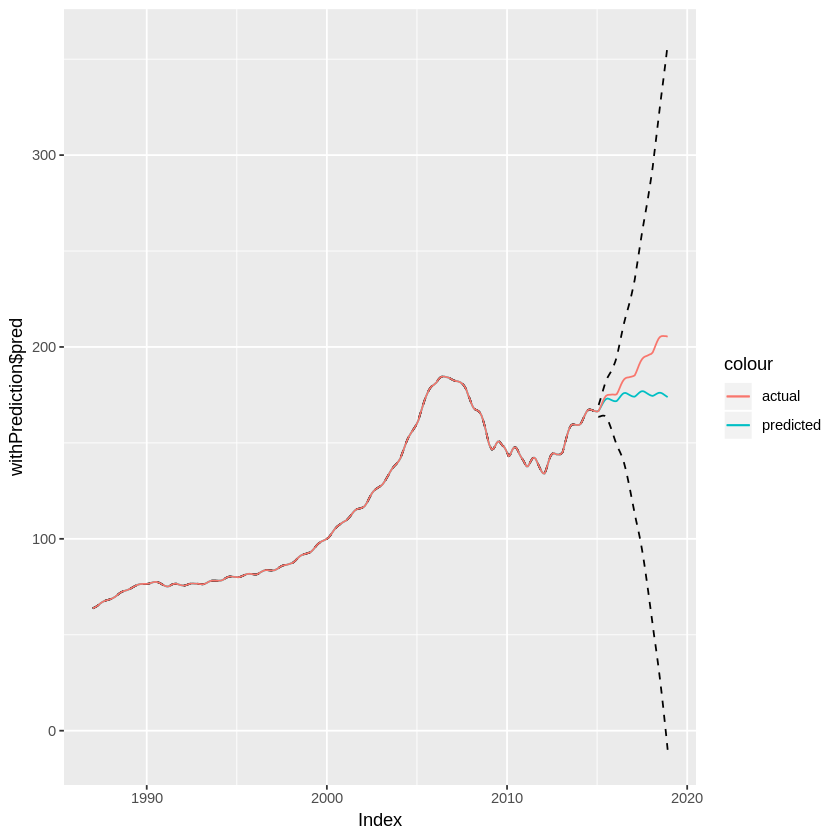

In [238]:
periodToForecast = 50
trainPeriod = nrow(HomePrice)-periodToForecast
train = HomePrice[1:trainPeriod]

fit = arima(train, order=c(0,2,0), seasonal=list(order=c(2,0,0),period=12),  method = "ML")
predictions = predict(fit,n.ahead=periodToForecast,se.fit=TRUE)

# Create vectors with prediction, 2 * SE bounds
pred = c()
upper = c()
lower = c()
for(i in 1:nrow(HomePrice)){
    if(i <= nrow(HomePrice) - periodToForecast){
        pred[i] = HomePrice$CSUSHPINSA[i]
        upper[i] = HomePrice$CSUSHPINSA[i]
        lower[i] = HomePrice$CSUSHPINSA[i]
    }else{
        p = i - trainPeriod
        pred[i] = predictions$pred[p]
        upper[i] = predictions$pred[p] + 2*predictions$se[p]
        lower[i] = predictions$pred[p] - 2*predictions$se[p]
    }
}

withPrediction = merge(HomePrice, pred, upper, lower)

ggplot(withPrediction, aes(Index)) + 
    geom_line(aes(y = withPrediction$pred, color="predicted")) +
    geom_line(aes(y = withPrediction$upper), linetype="dashed") +
    geom_line(aes(y = withPrediction$lower), , linetype="dashed") +
    geom_line(aes(y = withPrediction$CSUSHPINSA, color="actual"))

# acf(fit$residuals)
# pacf(fit$residuals)
